In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import cluster, datasets, metrics
import seaborn as sns

# Read the Abalone dataset

In [2]:
abalone_df = pd.read_csv('./abalone.csv',
                         names = ["Sex",
                                  "Length",
                                  "Diameter",
                                  "Height",
                                  "Whole weight",
                                  "Shucked weight",
                                  "Viscera weight",
                                  "Shell weight",
                                  "Rings"])
print('Shape:', abalone_df.shape)
abalone_df.head()

Shape: (4177, 9)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Compare the plots between each feature on the dataset

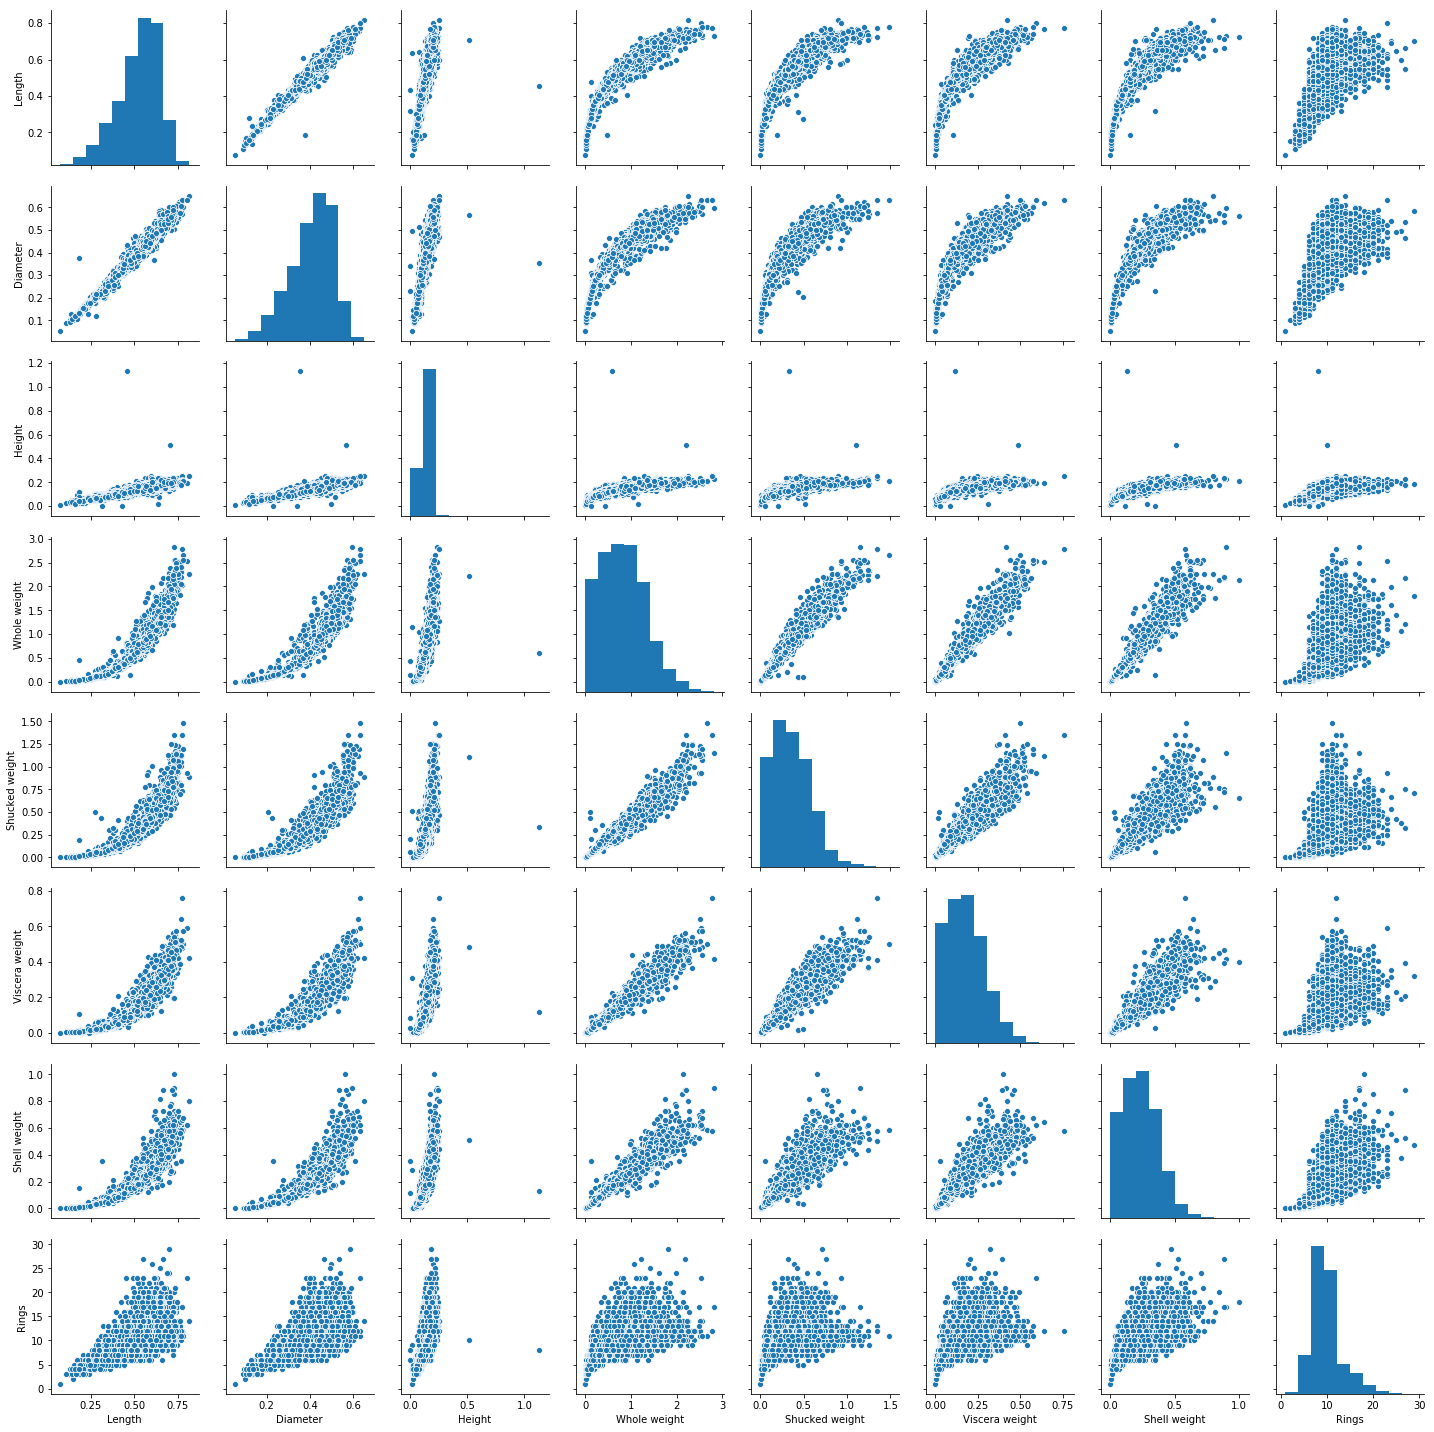

In [3]:
abalone_plot = sns.pairplot(abalone_df)

## Preprocessing the data
Converting the 'Sex' labels to numerical values <br/>
F - 0 <br/>
I - 1 <br/>
M - 2 <br/>

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(abalone_df.Sex)
list(le.classes_)

['F', 'I', 'M']

## Separate the input/output and split in training and testing

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = abalone_df.drop(columns='Rings')
X.Sex = le.transform(X.Sex)
y = abalone_df.Rings

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train[0:5]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
4125,1,0.540,0.415,0.135,0.7090,0.3195,0.174,0.1850
1178,0,0.650,0.500,0.190,1.4640,0.6415,0.339,0.4245
214,0,0.485,0.395,0.160,0.6600,0.2475,0.128,0.2350
1388,2,0.630,0.495,0.160,1.0930,0.4970,0.221,0.3150
2558,1,0.405,0.310,0.065,0.3205,0.1575,0.066,0.0880


## Get the predicted probabilities for each class with a Random Forest Classifier

Classes:
 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
First instance probability (training set):



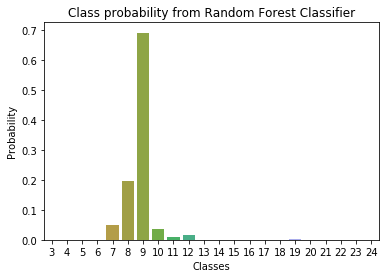

In [61]:
clf_rf = RandomForestClassifier(n_estimators=250)
clf_rf.fit(X_train, y_train)

y_pred_prob_rf = clf_rf.predict_proba(X_train)
y_pred_rf = clf_rf.predict(X_test)

print('Classes:\n', clf_rf.classes_)
print('First instance probability (training set):\n')

sns.barplot(x=clf_rf.classes_, y=y_pred_prob_rf[0])
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class probability from Random Forest Classifier')
plt.show()

In [62]:
print('Test set predictions (max probability):\n', y_pred_rf)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_rf))

Test set predictions (max probability):
 [ 8  7  9 ... 13  6 11]
Accuracy: 0.2551834130781499


## Plot the Feature Importance for the Random Forest Classifier

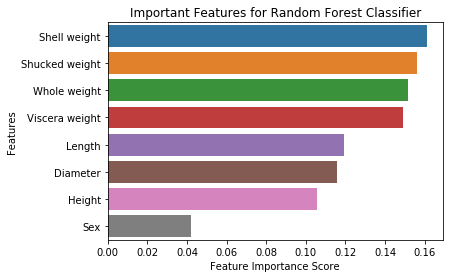

In [50]:
feature_imp = pd.Series(clf_rf.feature_importances_, index=X.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features for Random Forest Classifier")
plt.show()

## Knowledge Distillation with a Decision Tree Regressor

Classes:
 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
First instance probability (training set):



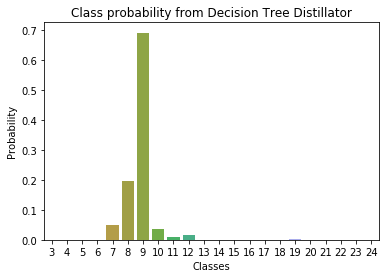

In [63]:
from sklearn import tree

clf_dtr = tree.DecisionTreeRegressor()

# Fit to continuous multiple output probability predictions
clf_dtr.fit(X_train, y_pred_prob_rf)

# Predict the probabilities on the test set
y_pred_prob_dtr = clf_dtr.predict(X_test)

# Find the max argument and identify the correct class
y_pred_idx_dtr = y_pred_prob_dtr.argmax(axis=1)
y_pred_dtr = []
for i in y_pred_idx_dtr:
    y_pred_dtr.append(clf_rf.classes_[i])

y_pred_dtr = np.array(y_pred_dtr)

print('Classes:\n', clf_rf.classes_)
y_pred_prob_train_dtr = clf_dtr.predict(X_train)
print('First instance probability (training set):\n')

sns.barplot(x=clf_rf.classes_, y=y_pred_prob_train_dtr[0])
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class probability from Decision Tree Distillator')
plt.show()

In [64]:
print('Predictions (max probability):\n', y_pred_dtr)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_dtr))

Predictions (max probability):
 [13  7  9 ...  9  6 12]
Accuracy: 0.18819776714513556


## Plot the Feature Importance for the Decision Tree Distillator

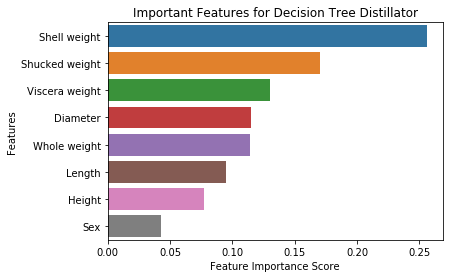

In [9]:
feature_imp = pd.Series(clf_dtr.feature_importances_, index=X.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features for Decision Tree Distillator")
plt.show()

## Decision Tree Classifier without Distillation

In [10]:
clf_dt = tree.DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

y_pred_dt = clf_dt.predict(X_test)

print('Predictions:\n', y_pred_dt)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_dt))

Predictions:
 [11  7 19 ...  8 11 13]
Accuracy: 0.20494417862838915


## Plot the Feature Importance for the Raw Decision Tree

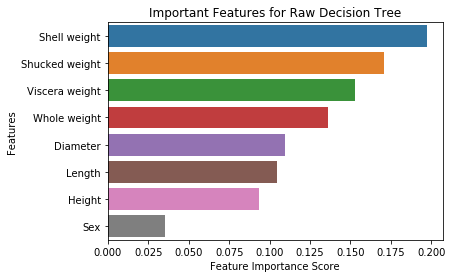

In [11]:
feature_imp = pd.Series(clf_dt.feature_importances_, index=X.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features for Raw Decision Tree")
plt.show()

## Repeat 100 times to obtain an average accuracy for the three methods

In [12]:
acc_rf = 0
acc_dtr = 0
acc_dt = 0
acc_rf_arr = []
acc_dtr_arr = []
acc_dt_arr = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Random Forest Classifier
    clf_rf.fit(X_train, y_train)
    y_pred_prob_rf = clf_rf.predict_proba(X_train)
    y_pred_rf = clf_rf.predict(X_test)
    acc_rf = acc_rf + metrics.accuracy_score(y_test, y_pred_rf)
    acc_rf_arr.append(acc_rf/(i+1))

    # Decision Tree Distillator
    clf_dtr.fit(X_train, y_pred_prob_rf)
    y_pred_prob_dtr = clf_dtr.predict(X_test)
    y_pred_idx_dtr = y_pred_prob_dtr.argmax(axis=1)
    y_pred_dtr = []
    for j in y_pred_idx_dtr:
        y_pred_dtr.append(clf_rf.classes_[j])
    y_pred_dtr = np.array(y_pred_dtr)
    acc_dtr = acc_dtr + metrics.accuracy_score(y_test, y_pred_dtr)
    acc_dtr_arr.append(acc_dtr/(i+1))
    
    # Raw Decision Tree
    clf_dt.fit(X_train, y_train)
    y_pred_dt = clf_dt.predict(X_test)
    acc_dt = acc_dt + metrics.accuracy_score(y_test, y_pred_dt)
    acc_dt_arr.append(acc_dt/(i+1))
    
print('Random forest average accuracy:', acc_rf_arr[-1])
print('Decision tree distillator average accuracy:', acc_dtr_arr[-1])
print('Raw decision tree average accuracy:', acc_dt_arr[-1])

Random forest average accuracy: 0.24839712918660287
Decision tree distillator average accuracy: 0.19814194577352462
Raw decision tree average accuracy: 0.19891547049441777


Plot the average accuracy through all iterations

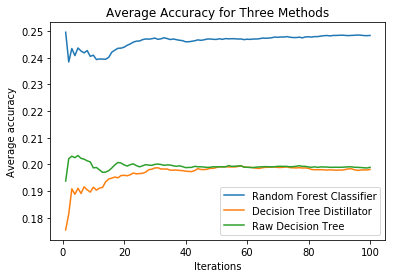

In [13]:
it = np.arange(1, 101)
plt.plot(it, acc_rf_arr, label='Random Forest Classifier')
plt.plot(it, acc_dtr_arr, label='Decision Tree Distillator')
plt.plot(it, acc_dt_arr, label='Raw Decision Tree')
plt.xlabel('Iterations')
plt.ylabel('Average accuracy')
plt.title('Average Accuracy for Three Methods')
plt.legend()
plt.show()

<br/>
<br/>
<br/>

# Read the Human Activity Recognition Using Smartphones dataset

In [66]:
X_train = pd.read_csv('./HAR_dataset/train/X_train.csv', delim_whitespace=True, header=None)
X_test = pd.read_csv('./HAR_dataset/test/X_test.csv', delim_whitespace=True, header=None)

y_train = pd.read_csv('./HAR_dataset/train/y_train.csv', delim_whitespace=True, header=None)
y_test = pd.read_csv('./HAR_dataset/test/y_test.csv', delim_whitespace=True, header=None)
#Input features
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [57]:
#Output (Numbers between 0-5 representing the 6 different possible actions)
y_train.head()

,0
0,5
1,5
2,5
3,5
4,5


## Compare the relation between features

For plotting purposes, only ten colums will be selected

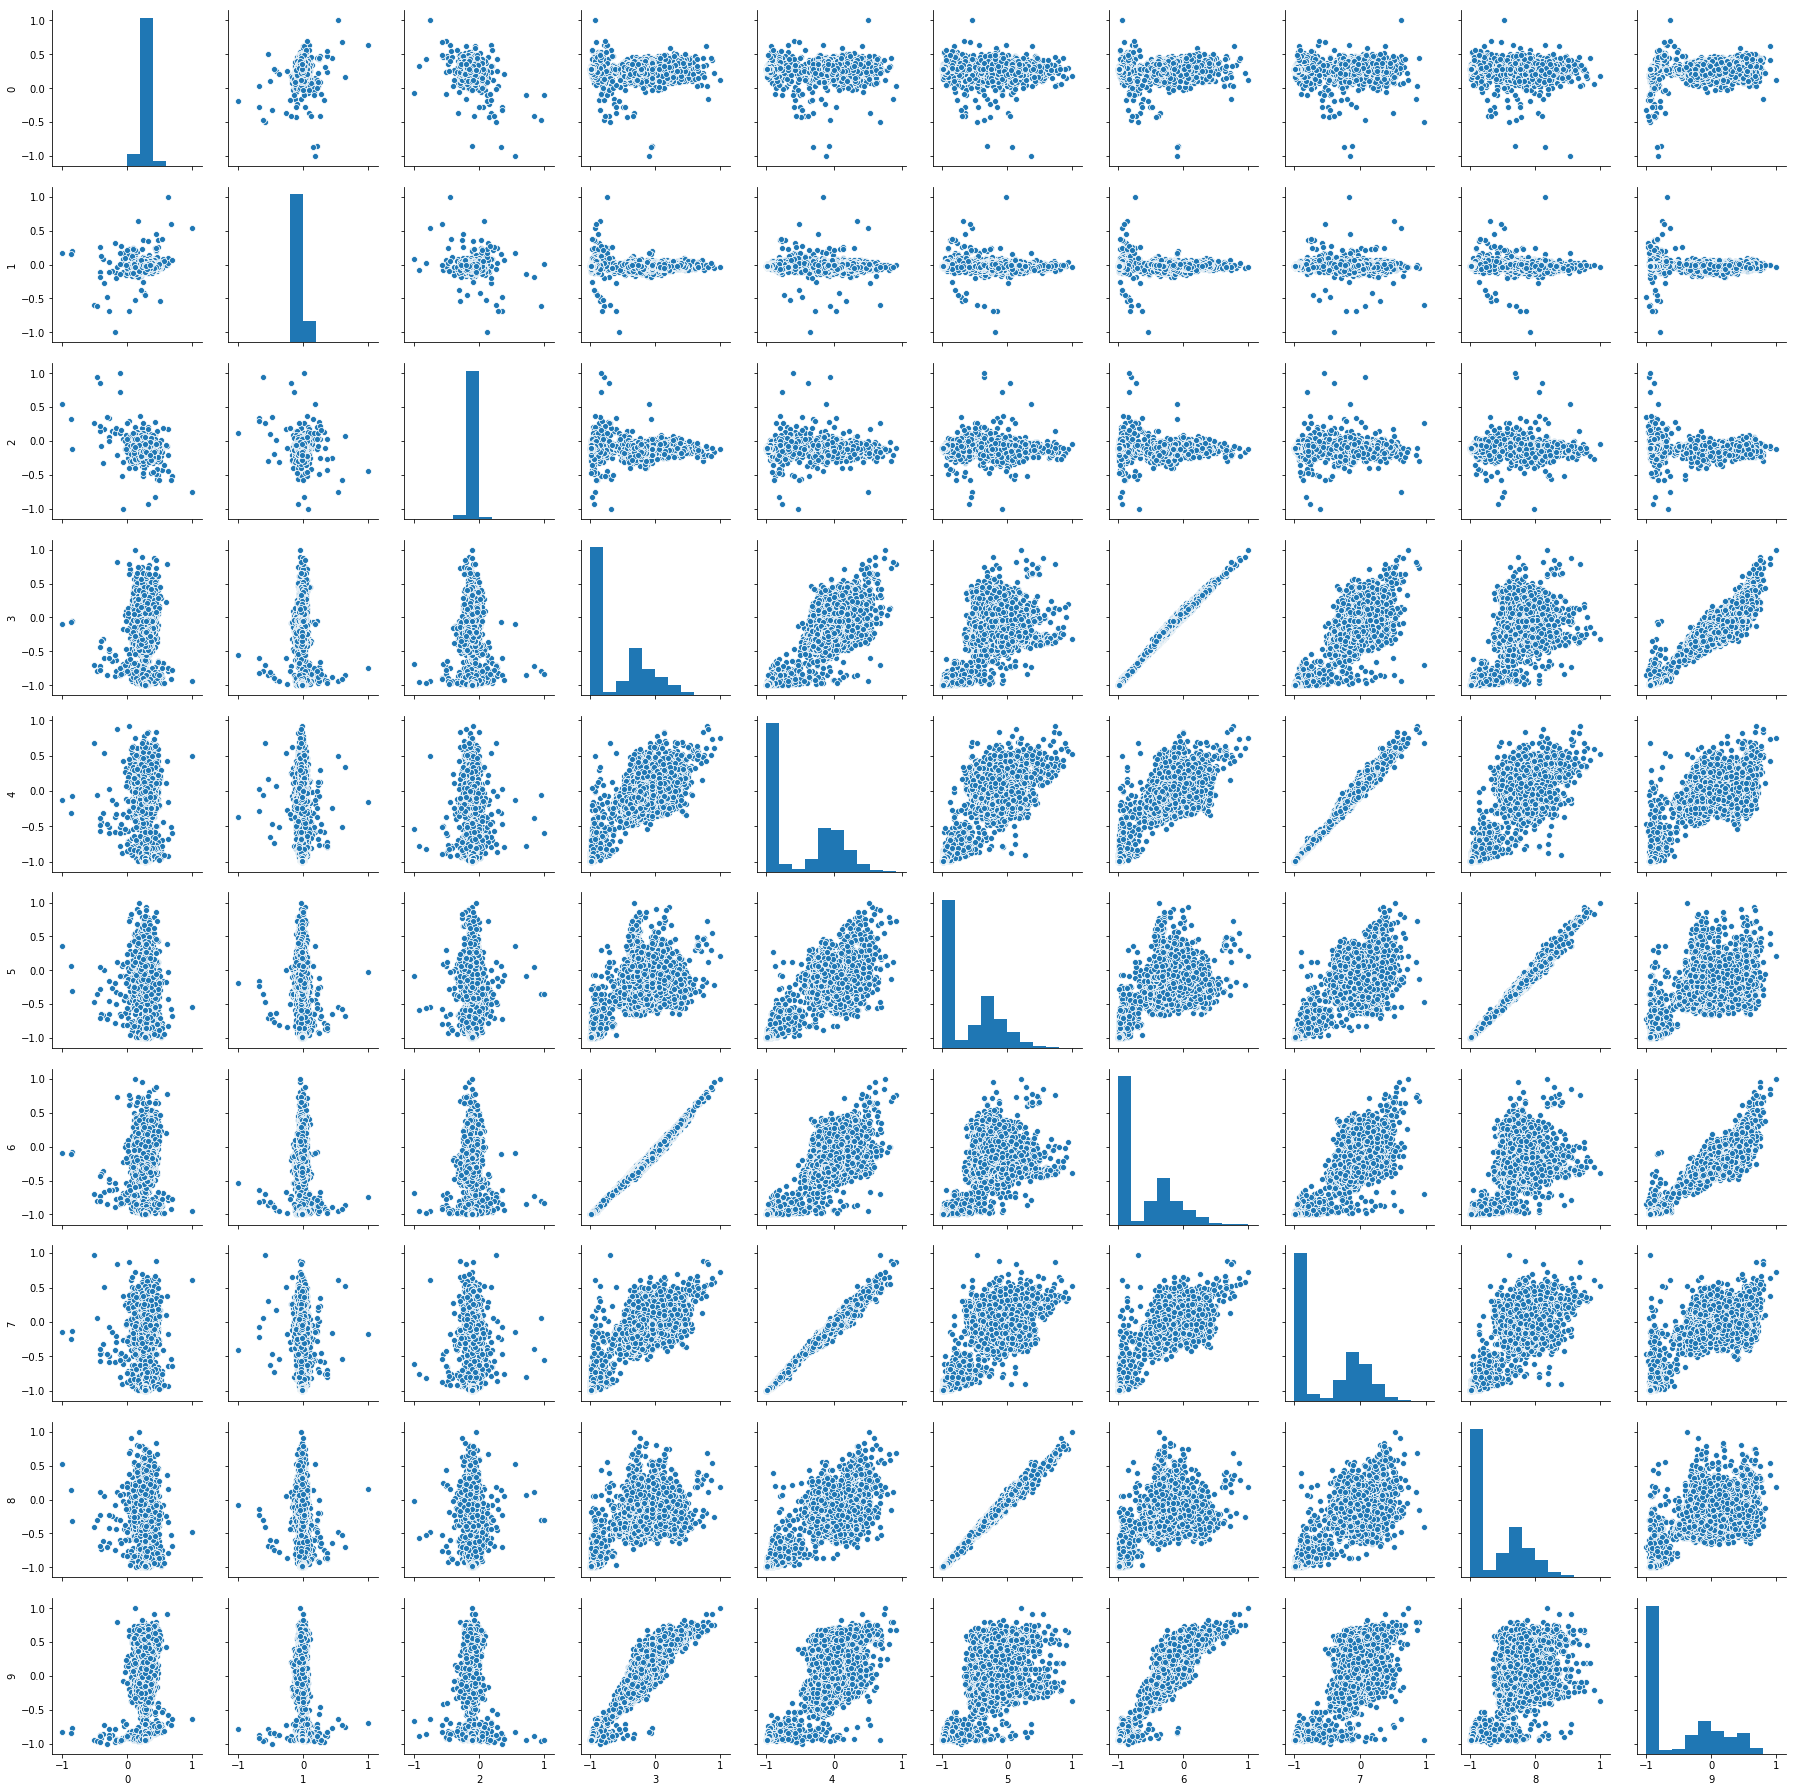

In [16]:
X_small = X_train.iloc[:,0:10]
HAR_plot = sns.pairplot(X_small)

## Get the predicted probabilities for each class with a Random Forest Classifier

Classes:
 [1 2 3 4 5 6]
First instance probability (training set):



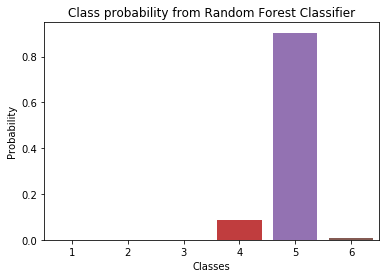

In [67]:
clf_rf = RandomForestClassifier(n_estimators=250)
clf_rf.fit(X_train, y_train.values.ravel())

y_pred_prob_rf = clf_rf.predict_proba(X_train)
y_pred_rf = clf_rf.predict(X_test)

print('Classes:\n', clf_rf.classes_)
print('First instance probability (training set):\n')

sns.barplot(x=clf_rf.classes_, y=y_pred_prob_rf[0])
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class probability from Random Forest Classifier')
plt.show()

In [68]:
print('Test set predictions (max probability):\n', y_pred_rf)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_rf))

Test set predictions (max probability):
 [5 5 5 ... 2 2 2]
Accuracy: 0.9246691550729556


## Plot the Feature Importance for the Random Forest Classifier

In [18]:
feature_imp = pd.Series(clf_rf.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)
feature_imp.head()

52     0.036631
56     0.031734
558    0.029193
41     0.028063
49     0.026569
dtype: float64

## Knowledge Distillation with a Decision Tree Regressor

Classes:
 [1 2 3 4 5 6]
First instance probability (training set):



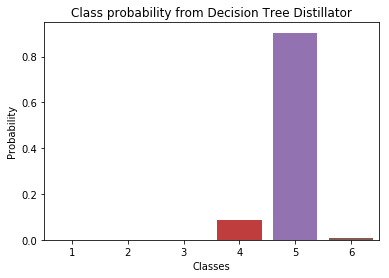

In [69]:
from sklearn import tree

clf_dtr = tree.DecisionTreeRegressor()

# Fit to continuous multiple output probability predictions
clf_dtr.fit(X_train, y_pred_prob_rf)

# Predict the probabilities on the test set
y_pred_prob_dtr = clf_dtr.predict(X_test)

# Find the max argument and identify the correct class
y_pred_idx_dtr = y_pred_prob_dtr.argmax(axis=1)
y_pred_dtr = []
for i in y_pred_idx_dtr:
    y_pred_dtr.append(clf_rf.classes_[i])

y_pred_dtr = np.array(y_pred_dtr)

print('Classes:\n', clf_rf.classes_)
y_pred_prob_train_dtr = clf_dtr.predict(X_train)
print('First instance probability (training set):\n')

sns.barplot(x=clf_rf.classes_, y=y_pred_prob_train_dtr[0])
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class probability from Decision Tree Distillator')
plt.show()

In [70]:
print('Predictions (max probability):\n', y_pred_dtr)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_dtr))

Predictions (max probability):
 [5 5 5 ... 2 1 2]
Accuracy: 0.8673227010519172


## Plot the Feature Importance for the Decision Tree Distillator

In [20]:
feature_imp = pd.Series(clf_dtr.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)
feature_imp.head()

52     0.252900
271    0.217341
559    0.131913
508    0.115191
74     0.099406
dtype: float64

## Decision Tree Classifier without Distillation

In [21]:
clf_dt = tree.DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

y_pred_dt = clf_dt.predict(X_test)

print('Predictions:\n', y_pred_dt)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_dt))

Predictions:
 [5 5 5 ... 2 1 3]
Accuracy: 0.8598574821852731


## Plot the Feature Importance for the Raw Decision Tree

In [22]:
feature_imp = pd.Series(clf_dt.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)
feature_imp.head()

52     0.239945
389    0.201332
559    0.132955
508    0.109366
74     0.096173
dtype: float64

## Repeat 100 times to obtain an average accuracy for the three methods

In [23]:
acc_rf = 0
acc_dtr = 0
acc_dt = 0
acc_rf_arr = []
acc_dtr_arr = []
acc_dt_arr = []
for i in range(100):
    # Random Forest Classifier
    clf_rf.fit(X_train, y_train.values.ravel())
    y_pred_prob_rf = clf_rf.predict_proba(X_train)
    y_pred_rf = clf_rf.predict(X_test)
    acc_rf = acc_rf + metrics.accuracy_score(y_test, y_pred_rf)
    acc_rf_arr.append(acc_rf/(i+1))
    
    # Decision Tree Distillator
    clf_dtr.fit(X_train, y_pred_prob_rf)
    y_pred_prob_dtr = clf_dtr.predict(X_test)
    y_pred_idx_dtr = y_pred_prob_dtr.argmax(axis=1)
    y_pred_dtr = []
    for j in y_pred_idx_dtr:
        y_pred_dtr.append(clf_rf.classes_[j])
    y_pred_dtr = np.array(y_pred_dtr)
    acc_dtr = acc_dtr + metrics.accuracy_score(y_test, y_pred_dtr)
    acc_dtr_arr.append(acc_dtr/(i+1))
    
    # Raw Decision Tree
    clf_dt.fit(X_train, y_train)
    y_pred_dt = clf_dt.predict(X_test)
    acc_dt = acc_dt + metrics.accuracy_score(y_test, y_pred_dt)
    acc_dt_arr.append(acc_dt/(i+1))
    
print('Random forest average accuracy:', acc_rf_arr[-1])
print('Decision tree distillator average accuracy:', acc_dtr_arr[-1])
print('Raw decision tree average accuracy:', acc_dt_arr[-1])

Random forest average accuracy: 0.9276450627757042
Decision tree distillator average accuracy: 0.8635833050559895
Raw decision tree average accuracy: 0.857315914489311


Plot the average accuracy through all iterations

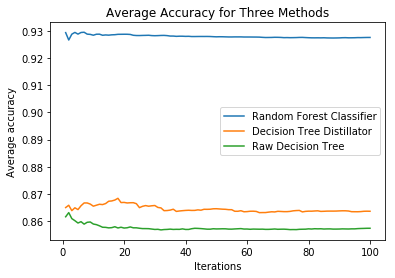

In [24]:
it = np.arange(1, 101)
plt.plot(it, acc_rf_arr, label='Random Forest Classifier')
plt.plot(it, acc_dtr_arr, label='Decision Tree Distillator')
plt.plot(it, acc_dt_arr, label='Raw Decision Tree')
plt.xlabel('Iterations')
plt.ylabel('Average accuracy')
plt.title('Average Accuracy for Three Methods')
plt.legend()
plt.show()

<br/>
<br/>
<br/>

# Read the Adult dataset

In [25]:
adult_df = pd.read_csv('./adult.csv',
                         names = ["Age",
                                  "Work-class",
                                  "Fnlwgt",
                                  "Education",
                                  "Education-num",
                                  "Marital-status",
                                  "Ocupation",
                                  "Relationship",
                                  "Race",
                                  "Sex",
                                  "Capital-gain",
                                  "Capital_loss",
                                  "Hours-per-week",
                                  "Native-country",
                                  "Income"])
adult_df.head()

,Age,Work-class,Fnlwgt,Education,Education-num,Marital-status,Ocupation,Relationship,Race,Sex,Capital-gain,Capital_loss,Hours-per-week,Native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Compare the plots between each feature on the dataset

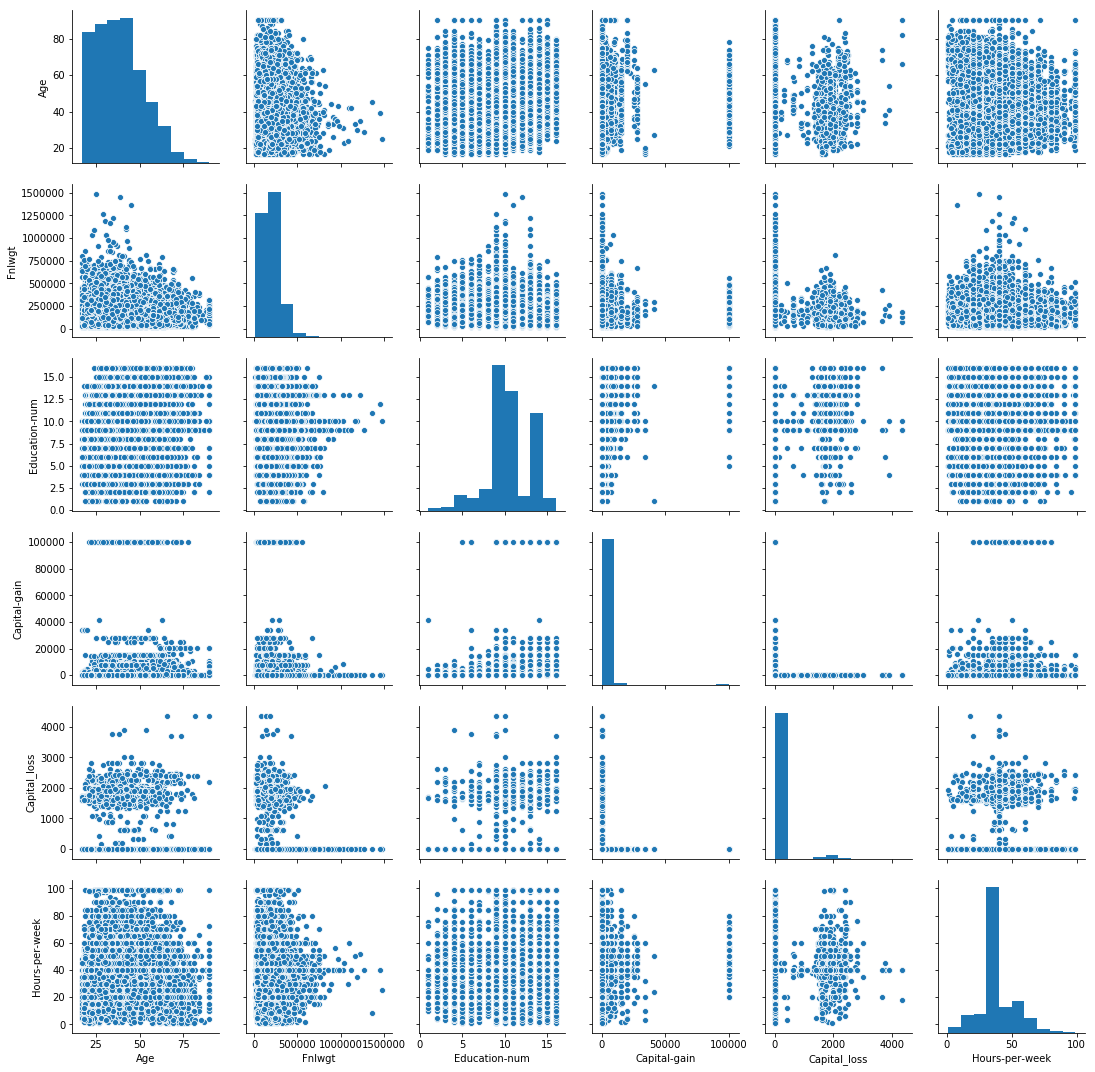

In [26]:
adult_plot = sns.pairplot(adult_df)

## Preprocessing the data
Converting non-numerical values to numerical values

In [27]:
from sklearn.preprocessing import LabelEncoder

le_wc = LabelEncoder()
le_wc.fit(adult_df['Work-class'])
list(le_wc.classes_)

[' ?',
 ' Federal-gov',
 ' Local-gov',
 ' Never-worked',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay']

In [28]:
le_ed = LabelEncoder()
le_ed.fit(adult_df['Education'])
list(le_ed.classes_)

[' 10th',
 ' 11th',
 ' 12th',
 ' 1st-4th',
 ' 5th-6th',
 ' 7th-8th',
 ' 9th',
 ' Assoc-acdm',
 ' Assoc-voc',
 ' Bachelors',
 ' Doctorate',
 ' HS-grad',
 ' Masters',
 ' Preschool',
 ' Prof-school',
 ' Some-college']

In [29]:
le_ms = LabelEncoder()
le_ms.fit(adult_df['Marital-status'])
list(le_ms.classes_)

[' Divorced',
 ' Married-AF-spouse',
 ' Married-civ-spouse',
 ' Married-spouse-absent',
 ' Never-married',
 ' Separated',
 ' Widowed']

In [30]:
le_oc = LabelEncoder()
le_oc.fit(adult_df['Ocupation'])
list(le_oc.classes_)

[' ?',
 ' Adm-clerical',
 ' Armed-Forces',
 ' Craft-repair',
 ' Exec-managerial',
 ' Farming-fishing',
 ' Handlers-cleaners',
 ' Machine-op-inspct',
 ' Other-service',
 ' Priv-house-serv',
 ' Prof-specialty',
 ' Protective-serv',
 ' Sales',
 ' Tech-support',
 ' Transport-moving']

In [31]:
le_re = LabelEncoder()
le_re.fit(adult_df['Relationship'])
list(le_re.classes_)

[' Husband',
 ' Not-in-family',
 ' Other-relative',
 ' Own-child',
 ' Unmarried',
 ' Wife']

In [32]:
le_ra = LabelEncoder()
le_ra.fit(adult_df['Race'])
list(le_ra.classes_)

[' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White']

In [33]:
le_sx = LabelEncoder()
le_sx.fit(adult_df['Sex'])
list(le_sx.classes_)

[' Female', ' Male']

In [34]:
le_nc = LabelEncoder()
le_nc.fit(adult_df['Native-country'])
list(le_nc.classes_)

[' ?',
 ' Cambodia',
 ' Canada',
 ' China',
 ' Columbia',
 ' Cuba',
 ' Dominican-Republic',
 ' Ecuador',
 ' El-Salvador',
 ' England',
 ' France',
 ' Germany',
 ' Greece',
 ' Guatemala',
 ' Haiti',
 ' Holand-Netherlands',
 ' Honduras',
 ' Hong',
 ' Hungary',
 ' India',
 ' Iran',
 ' Ireland',
 ' Italy',
 ' Jamaica',
 ' Japan',
 ' Laos',
 ' Mexico',
 ' Nicaragua',
 ' Outlying-US(Guam-USVI-etc)',
 ' Peru',
 ' Philippines',
 ' Poland',
 ' Portugal',
 ' Puerto-Rico',
 ' Scotland',
 ' South',
 ' Taiwan',
 ' Thailand',
 ' Trinadad&Tobago',
 ' United-States',
 ' Vietnam',
 ' Yugoslavia']

In [35]:
le_in = LabelEncoder()
le_in.fit(adult_df['Income'])
list(le_in.classes_)

[' <=50K', ' >50K']

## Separate the input/output and split in training and testing

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = adult_df.drop(columns='Income')
X['Work-class'] = le_wc.transform(X['Work-class'])
X['Education'] = le_ed.transform(X['Education'])
X['Marital-status'] = le_ms.transform(X['Marital-status'])
X['Ocupation'] = le_oc.transform(X['Ocupation'])
X['Relationship'] = le_re.transform(X['Relationship'])
X['Race'] = le_ra.transform(X['Race'])
X['Sex'] = le_sx.transform(X['Sex'])
X['Native-country'] = le_nc.transform(X['Native-country'])

y = adult_df.Income
y = le_in.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X.head()

,Age,Work-class,Fnlwgt,Education,Education-num,Marital-status,Ocupation,Relationship,Race,Sex,Capital-gain,Capital_loss,Hours-per-week,Native-country
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5


## Get the predicted probabilities for each class with a Random Forest Classifier

Classes:
 [0 1]
First instance probability (training set):



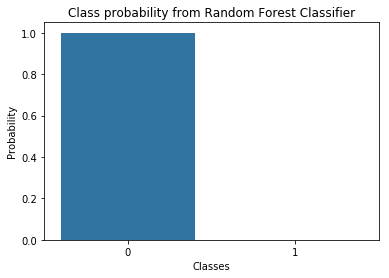

In [72]:
clf_rf = RandomForestClassifier(n_estimators=250)
clf_rf.fit(X_train, y_train)

y_pred_prob_rf = clf_rf.predict_proba(X_train)
y_pred_rf = clf_rf.predict(X_test)

print('Classes:\n', clf_rf.classes_)
print('First instance probability (training set):\n')

sns.barplot(x=clf_rf.classes_, y=y_pred_prob_rf[0])
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class probability from Random Forest Classifier')
plt.show()

In [73]:
print('Test set predictions (max probability):\n', y_pred_rf)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_rf))

Test set predictions (max probability):
 [0 0 0 ... 1 0 0]
Accuracy: 0.8555635172484389


## Plot the Feature Importance for the Random Forest Classifier

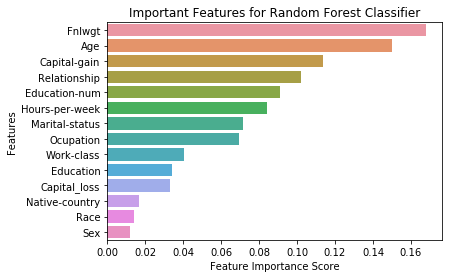

In [38]:
feature_imp = pd.Series(clf_rf.feature_importances_, index=X.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features for Random Forest Classifier")
plt.show()

## Knowledge Distillation with a Decision Tree Regressor

Classes:
 [0 1]
First instance probability (training set):



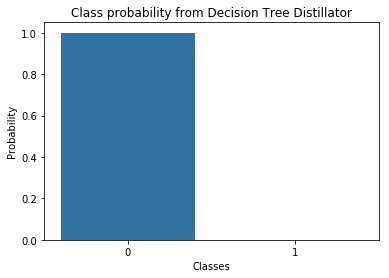

In [74]:
from sklearn import tree

clf_dtr = tree.DecisionTreeRegressor()

# Fit to continuous multiple output probability predictions
clf_dtr.fit(X_train, y_pred_prob_rf)

# Predict the probabilities on the test set
y_pred_prob_dtr = clf_dtr.predict(X_test)

# Find the max argument and identify the correct class
y_pred_idx_dtr = y_pred_prob_dtr.argmax(axis=1)
y_pred_dtr = []
for i in y_pred_idx_dtr:
    y_pred_dtr.append(clf_rf.classes_[i])

y_pred_dtr = np.array(y_pred_dtr)

print('Classes:\n', clf_rf.classes_)
y_pred_prob_train_dtr = clf_dtr.predict(X_train)
print('First instance probability (training set):\n')

sns.barplot(x=clf_rf.classes_, y=y_pred_prob_train_dtr[0])
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class probability from Decision Tree Distillator')
plt.show()

In [75]:
print('Predictions (max probability):\n', y_pred_dtr)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_dtr))

Predictions (max probability):
 [0 1 0 ... 0 0 1]
Accuracy: 0.8094994369945747


## Plot the Feature Importance for the Decision Tree Distillator

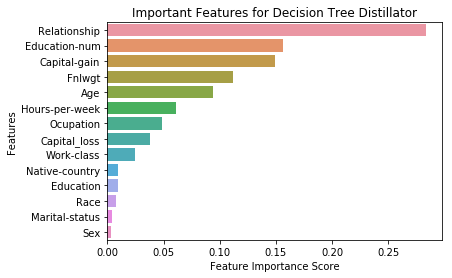

In [40]:
feature_imp = pd.Series(clf_dtr.feature_importances_, index=X.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features for Decision Tree Distillator")
plt.show()

## Decision Tree Classifier without Distillation

In [41]:
clf_dt = tree.DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

y_pred_dt = clf_dt.predict(X_test)

print('Predictions:\n', y_pred_dt)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_dt))

Predictions:
 [0 0 0 ... 0 0 0]
Accuracy: 0.8104207185996519


## Plot the Feature Importance for the Raw Decision Tree

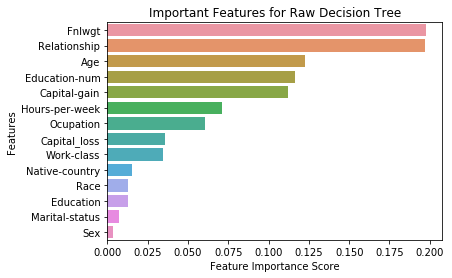

In [42]:
feature_imp = pd.Series(clf_dt.feature_importances_, index=X.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features for Raw Decision Tree")
plt.show()

## Repeat 100 times to obtain an average accuracy for the three methods

In [43]:
acc_rf = 0
acc_dtr = 0
acc_dt = 0
acc_rf_arr = []
acc_dtr_arr = []
acc_dt_arr = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Random Forest Classifier
    clf_rf.fit(X_train, y_train)
    y_pred_prob_rf = clf_rf.predict_proba(X_train)
    y_pred_rf = clf_rf.predict(X_test)
    acc_rf = acc_rf + metrics.accuracy_score(y_test, y_pred_rf)
    acc_rf_arr.append(acc_rf/(i+1))

    # Decision Tree Distillator
    clf_dtr.fit(X_train, y_pred_prob_rf)
    y_pred_prob_dtr = clf_dtr.predict(X_test)
    y_pred_idx_dtr = y_pred_prob_dtr.argmax(axis=1)
    y_pred_dtr = []
    for j in y_pred_idx_dtr:
        y_pred_dtr.append(clf_rf.classes_[j])
    y_pred_dtr = np.array(y_pred_dtr)
    acc_dtr = acc_dtr + metrics.accuracy_score(y_test, y_pred_dtr)
    acc_dtr_arr.append(acc_dtr/(i+1))
    
    # Raw Decision Tree
    clf_dt.fit(X_train, y_train)
    y_pred_dt = clf_dt.predict(X_test)
    acc_dt = acc_dt + metrics.accuracy_score(y_test, y_pred_dt)
    acc_dt_arr.append(acc_dt/(i+1))
    
print('Random forest average accuracy:', acc_rf_arr[-1])
print('Decision tree distillator average accuracy:', acc_dtr_arr[-1])
print('Raw decision tree average accuracy:', acc_dt_arr[-1])

Random forest average accuracy: 0.857485924864367
Decision tree distillator average accuracy: 0.810443238816665
Raw decision tree average accuracy: 0.8093847886170541


Plot the average accuracy through all iterations

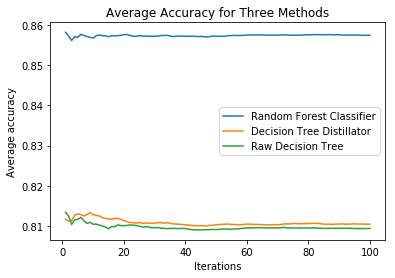

In [44]:
it = np.arange(1, 101)
plt.plot(it, acc_rf_arr, label='Random Forest Classifier')
plt.plot(it, acc_dtr_arr, label='Decision Tree Distillator')
plt.plot(it, acc_dt_arr, label='Raw Decision Tree')
plt.xlabel('Iterations')
plt.ylabel('Average accuracy')
plt.title('Average Accuracy for Three Methods')
plt.legend()
plt.show()